# <font color=blue> 기계학습 기초 12장: 군집화 </font>

## Cell clustering 

###  Machine Learning and Bioinformatics (MLBI) Lab @ DKU, 2020.07.04 <br>

In [2]:
import datetime as dt
import scipy.stats
import math
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import cluster, mixture
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sb

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
## Function to draw 2D scatter plot conveniently
def draw_scatter(pnt_2d, y, Title = None):
    
    colors = list('brgcymbrgcymbrgcymbrgcym')
    markers = list('sdov*+xsdov*+xsdov*+x')
    C_map = cm.get_cmap('Spectral', 256)  # 'viridis'
    
    plt.figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

    ## Under the original label
    plt.subplot(2,2,1)
    scatters = []      
    z = y
    y_label = list(set(z))
    nl = len(y_label)-1
    for k, lbl in enumerate(y_label):
        n = y_label[k]
        scatters.append(plt.scatter(pnt_2d[z==n, 0], pnt_2d[z==n, 1], \
                                    color=C_map(k/nl), # marker=markers[k], \
                                    label=lbl, s = 12))

    plt.legend( tuple(scatters),
                tuple(y_label),
                scatterpoints=1,
                loc='upper left',
                ncol=1, # len(scatters),                                                                                                 
                fontsize=10)
    plt.xlabel('UC 1')
    plt.ylabel('UC 2')
    if Title is not None: 
        plt.title(Title, fontsize=11)
    plt.grid()


## 1. Preprocessing and check data

In [13]:
## (1) read GEP
file_name = 'PBMC3K_expr.csv'
df_ge = pd.read_csv(file_name, index_col=0)
print("Data size (n_sample,n_features): ",end='')
print(df_ge.shape)

Data size (n_sample,n_features): (13714, 2700)


In [14]:
df_ge

,AAACATACAACCAC,AAACATTGAGCTAC,AAACATTGATCAGC,AAACCGTGCTTCCG,AAACCGTGTATGCG,AAACGCACTGGTAC,AAACGCTGACCAGT,AAACGCTGGTTCTT,AAACGCTGTAGCCA,AAACGCTGTTTCTG,...,TTTCAGTGTCACGA,TTTCAGTGTCTATC,TTTCAGTGTGCAGT,TTTCCAGAGGTGAG,TTTCGAACACCTGA,TTTCGAACTCTCAT,TTTCTACTGAGGCA,TTTCTACTTCCTCG,TTTGCATGAGAGGC,TTTGCATGCCTCAC
AL627309.1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
AP006222.2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
RP11-206L10.2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
RP11-206L10.9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
LINC00115,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC145212.1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
AL592183.1,0.0,1.111715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
AL354822.1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.378132,0.0
PNRC2.1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


## 2. Dimension reduction using PCA

In [23]:
N_components = 15
pca_obj = PCA(n_components = N_components, copy = True, random_state = 0)
pca_res = pca_obj.fit(df_ge.transpose())

X = pca_res.components_.dot(df_ge) 
df_ge_pca = pd.DataFrame(X, columns = df_ge.columns)

In [25]:
print(pca_res.components_.shape, df_ge.shape, df_ge_pca.shape)
print(pca_res.explained_variance_ratio_)
np.sum(pca_res.explained_variance_ratio_)

(15, 13714) (13714, 2700) (15, 2700)
[0.04532915 0.01606573 0.01147967 0.01002254 0.00435096 0.0033946
 0.00283841 0.0027773  0.00254025 0.00201152 0.00178742 0.00167252
 0.0016135  0.00153796 0.00143886]


0.10886038787105981

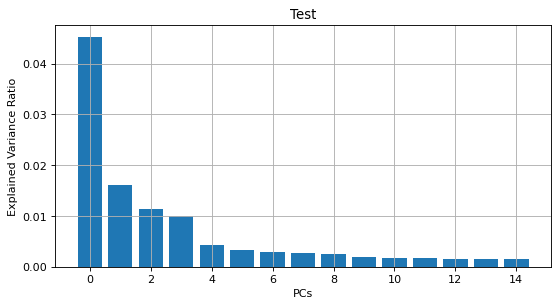

In [26]:
plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

plt.bar(df_ge_pca.index, res.explained_variance_ratio_)
plt.xlabel('PCs')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.title('Test')
plt.show()

## 4. tSNE Plot: Visualization of sample distribution
#### Getting 2D tSNE projection

In [29]:
pnt_2d_tsne = TSNE(learning_rate=300).fit_transform(X.transpose())
pnt_2d = pnt_2d_tsne

In [30]:
pnt_2d.shape, X.shape

((2700, 2), (15, 2700))

#### Draw tSNE plot

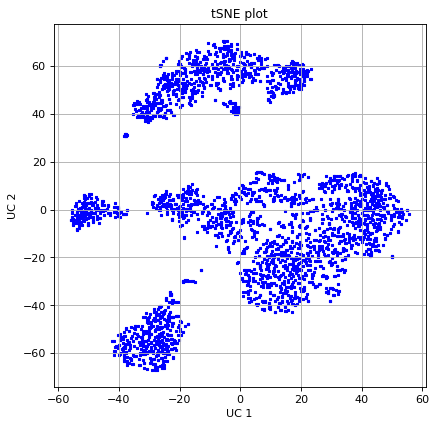

In [31]:
## Draw tSNE plot
colors = list('brgcym')
markers = list('sdov*+')
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(pnt_2d_tsne[:, 0], pnt_2d_tsne[:, 1], color = 'b', marker=markers[0], s = 6)
plt.xlabel('UC 1')
plt.ylabel('UC 2')
plt.title('tSNE plot', fontsize=11)
plt.grid()


## 5a. Clustering using k-means algorithm (Partitioning)

### 3 steps

1. Set model hyper parameters
2. Fit the model to the data matrix (each row is a sample, each column is a feature)
3. Get cluster label

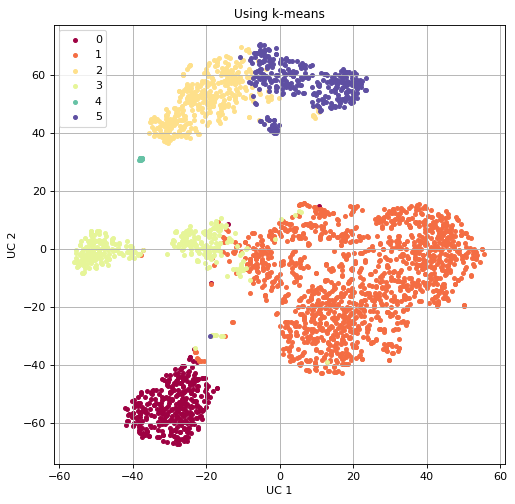

In [32]:
N_clusters = 6
km = cluster.KMeans(n_clusters = N_clusters, random_state = 1)
km.fit(X.transpose())
y = km.labels_

draw_scatter(pnt_2d, y, 'Using k-means')

## 5b. Clustering using DBSCAN (Density based)

Number of clusters: 7


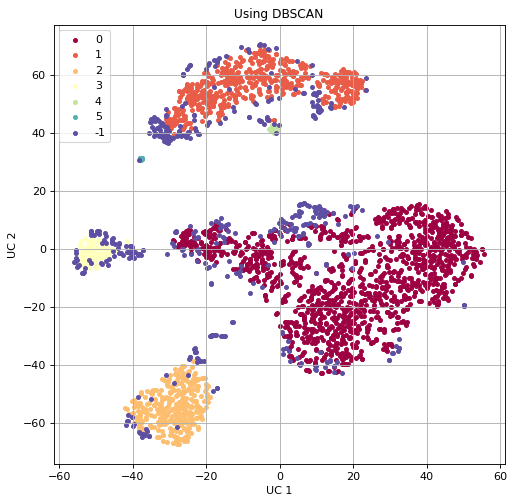

In [36]:
dbscn = cluster.DBSCAN(eps=6, min_samples=10)
dbscn.fit(X.transpose())
y = dbscn.labels_ 

print('Number of clusters: %i' % len(set(y)) )
draw_scatter(pnt_2d, y, 'Using DBSCAN')

## 5c. Clustering using GMM (Distribution based)

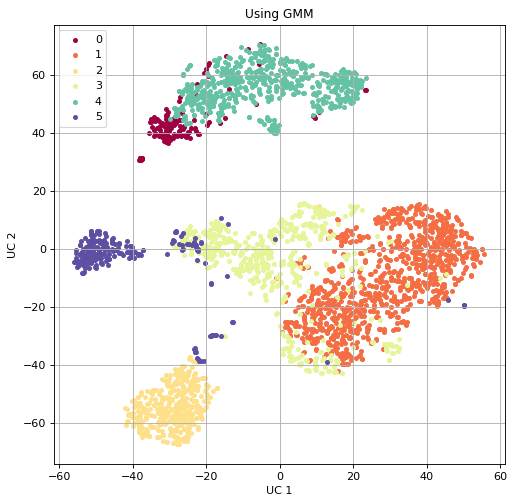

In [37]:
N_clusters = 6
gmm = mixture.GaussianMixture(n_components = N_clusters, random_state = 0)
y = gmm.fit_predict(X.transpose())

draw_scatter(pnt_2d, y, 'Using GMM') 

## Homework

#### 1. Refer to the following link to study other clustering algorithms.

https://scikit-learn.org/stable/modules/classes.html 

And perform clustering and plot UMAP as did in the previous examples.

Specifically, try the followings

1. AffinityPropagation
2. AgglomerativeClustering
3. Birch
4. FeatureAgglomeration
5. MiniBatchKMeans
6. MeanShift
7. OPTICS
8. SpectralClustering
9. SpectralBiclustering
10. SpectralCoclustering

#### 2. try to use the 2-dimensional UMAP or tSNE points to cluster using

1. k-means
2. DBSCAN
3. GMM

#### 3. Use the cluster label obtained by DBSCAN (except unconnected samples) to train linear classifier and determine the labels of the unconnected samples.